In [1]:
%run ./startup.py

/home/stest683/.pyenv/versions/2.7.15/envs/clims2/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Substances 

Samples are instances of `Substance`s. `Substance`s in turn are what we call `Extensible`. Such objects can be extended by plugins in a simple way. 

## Creating a custom sample type

Let's imagine that the Icelandic Wood Fibre Centre wants to install the LIMS for their research. They would probably require a sample type that is not that much alike one used in, let's say genomics.

After discussions with domain specialists, they decide they need the following custom fields:

* flammability 
* weight 
* width
* comment

In Commmon LIMS, this is defined in a plugin by creating a class that inherits from SubstanceBase: 

In [2]:
class WoodSample(SubstanceBase):
    flammability = FloatField("flammability") 
    weight = FloatField("weight")
    width = FloatField("width")
    comment = TextField("comment")

## Registering the new type

To register the type, the user will just have to pip install their plugin and then run upgrade, like this:

```
pip install icelandic_wood_fibre_centre
lims upgrade
```

Here, we'll simulate that with the equivelant programmatic version:

In [3]:
app.extensibles.register(notebook_plugin, WoodSample)

<ExtensibleType at 0x7fe8ab5c61d0: id=1L, name=u'__main__.WoodSample'>

## Using the newly registered type in handlers

Plugin developers can now easily create samples of their custom type. Since the type is a `Substance` it will get the following features out of the box:

* Immutability - all changes lead to new versions in the database
* Version history
* Ancestry: Create children (aliquots) from parent samples, retaining all the information from the parent

Here are a few examples:

In [4]:
# Create a new sample:
import random
name = "sample-{}".format(random.randint(1, 1000000))
sample = WoodSample(name=name, organization=org)
sample.save()

print("Created: {}, version {}, created {}".format(
    sample.name, sample.version, sample.created_at))

Created: sample-917365, version 1, created 2019-10-21 19:39:52.794180+00:00


In [5]:
# Now, let's add a few properties to this sample and see if the version changes:
sample.flammability = 0.9
sample.weight = 1
sample.comment = "Looks good to me!"
sample.save()
sample.comment = "Just kidding"
sample.save()

print("Updated: {}, version {}".format(sample.name, sample.version))

Updated: sample-917365, version 3


In [6]:
# Let's create an aliquot:
aliquot = sample.create_child(name=sample.name + "-aliquot")
print("Created: {}, version {}".format(aliquot.name, aliquot.version))

Created: sample-917365-aliquot, version 1


In [7]:
# By default, this aliquot has the same values as the parent:

print(aliquot.flammability)
print(aliquot.weight)
print(aliquot.comment)

0.9
1.0
Just kidding


In [8]:
# It's up to the plugin handlers what happens to a sample, let's for example
# cut the weight in half:

aliquot.weight *= 0.175
aliquot.comment = "No this actually looks bad"
aliquot.save()
sample.weight -= aliquot.weight
sample.save()

In [9]:
print(aliquot.flammability)
print(aliquot.weight)
print(aliquot.comment)

0.9
0.175
No this actually looks bad


## Viewing historical data

In [10]:
# We can trace the exact changes of both the aliquot and the sample
# NOTE: The API for this will be more user friendly later

def report(header, sample):
    print(header)
    for s in sample.iter_versions():
        print("{}: {}".format(
            s.version, {key: prop.value for key, prop in s.properties.items()}))
    print("")
    print("")

report("*** Sample property history ***", sample)
report("*** Aliquot property history ***", aliquot)

*** Sample property history ***
1: {}
2: {u'comment': u'Looks good to me!', u'flammability': 0.9, u'weight': 1.0}
3: {u'comment': u'Just kidding', u'flammability': 0.9, u'weight': 1.0}
4: {u'comment': u'Just kidding', u'flammability': 0.9, u'weight': 0.825}


*** Aliquot property history ***
1: {u'comment': u'Just kidding', u'flammability': 0.9, u'weight': 1.0}
2: {u'comment': u'No this actually looks bad', u'flammability': 0.9, u'weight': 0.175}




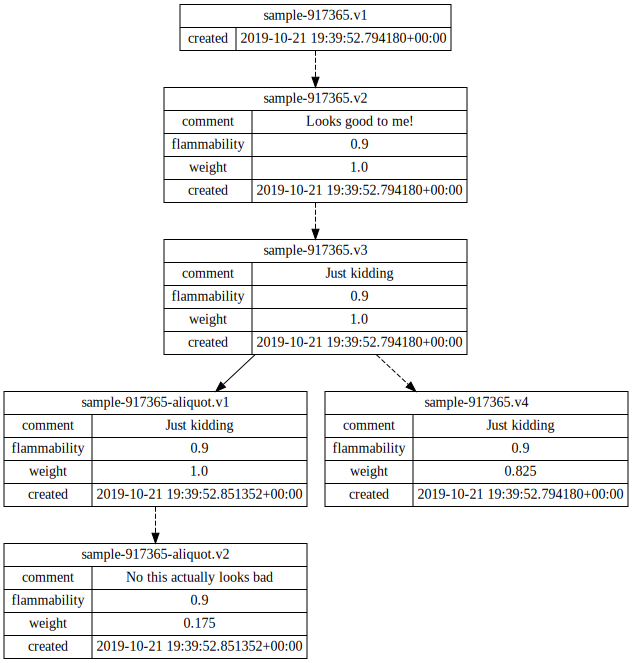

In [11]:
# Finally, we can view the sample as an SVG graph through the ancestry object:
sample.to_ancestry().to_svg()

# It shows version changes with a dashed edge and parent/child relations with
# an unbroken line

In [12]:
# DETAILS FOR DEVELOPERS
# The graph is built using graphviz. The source is generated by uncommenting
# the following line

# print(sample.to_ancestry().to_graphviz_src())

In [13]:
# DETAILS FOR DEVELOPERS
# You can then test the design by pasting in the source above here:
# Look at the documentation here: http://www.graphviz.org/documentation/
from graphviz import Source

s = Source("""
# PASTE BELOW HERE 
""")
s

In [30]:
# Let's create several samples:
import time
import random
from django.db import transaction

def create_samples(n):
    start = time.time()
    for ix in range(n):
        name = unique_name("sample")
        sample = WoodSample(name=name, organization=org)
        sample.comment = "testing"
        sample.save()
    print(time.time() - start)

create_samples(100)

0.737236976624


In [15]:
    from clims.workflow import WorkflowEngine

client = WorkflowEngine()                                                                                                                                                
variables = {                                                                                                                                                            
    "method": "TruSeq methylation",                                                                                                                                      
    "sample_type": "rna",                                                                                                                                                
    "sequencer": "HiSeq X"                                                                                                                                               
}
client.start_process("clims_snpseq.core.workflows.sequence", "samplex-1", variables)
client.start_process("clims_snpseq.core.workflows.sequence", "samplex-1", variables)   

variables = {                                                                                                                                                            
    "method": "Ready-made libraries",                                                                                                                                      
    "sample_type": "rna",                                                                                                                                                
    "sequencer": "HiSeq X"                                                                                                                                               
}
client.start_process("clims_snpseq.core.workflows.sequence", "samplex-1", variables)

19:39:53 [INFO] clims.workflow: Starting process clims_snpseq.core.workflows.sequence (businessKey=u'samplex-1' variables={'method': {'value': 'TruSeq methylation'}, 'sequencer': {'value': 'HiSeq X'}, 'sample_type': {'value': 'rna'}})
19:39:53 [INFO] clims.workflow: Starting process clims_snpseq.core.workflows.sequence (businessKey=u'samplex-1' variables={'method': {'value': 'TruSeq methylation'}, 'sequencer': {'value': 'HiSeq X'}, 'sample_type': {'value': 'rna'}})
19:39:53 [INFO] clims.workflow: Starting process clims_snpseq.core.workflows.sequence (businessKey=u'samplex-1' variables={'method': {'value': 'Ready-made libraries'}, 'sequencer': {'value': 'HiSeq X'}, 'sample_type': {'value': 'rna'}})


{u'businessKey': u'samplex-1',
 u'caseInstanceId': None,
 u'definitionId': u'f1f3f0ec-f17e-11e9-af6a-02425051e43d',
 u'ended': False,
 u'id': u'8d8a9253-f43a-11e9-af6a-02425051e43d',
 u'links': [{u'href': u'http://localhost:8080/engine-rest/process-instance/8d8a9253-f43a-11e9-af6a-02425051e43d',
   u'method': u'GET',
   u'rel': u'self'}],
 u'suspended': False,
 u'tenantId': None}